In [ ]:
!pip install opencv-python
!pip install pandas
!pip install matplotlib
!pip install gdown
!pip install sklearn
!pip install scipy
!pip install imutils
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [35]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import gdown as gdown
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms.transforms import Normalize

In [36]:
from Models.Models import *

In [2]:
url =  'https://drive.google.com/uc?export=download&id=1UGNAWPEe2YtkZNx3chPJRNbJMyHXU3Z6'
output = 'A_Z Handwritten Data.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1UGNAWPEe2YtkZNx3chPJRNbJMyHXU3Z6
To: C:\Users\Jorge\AI\A_Z Handwritten Data.csv
100%|██████████| 699M/699M [00:50<00:00, 13.7MB/s] 


'A_Z Handwritten Data.csv'

In [37]:
PATH = os.getcwd()
data = pd.read_csv(PATH + "/A_Z Handwritten Data.csv", header=None).astype('float32').to_numpy()
# column 0 = label
print(data.shape)
letterToNumber = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
numberToLetter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
classes = 26

(372451, 785)


In [38]:
letters = []
labels = []
for i in range(classes):
    labels_v = np.zeros(classes, dtype=np.float32)
    labels_v[i] = 1.0
    labels.append(torch.tensor(labels_v))
    letters.append([])

x_data = data[:, 1:]
y_data = data[:, 0]
normalizer = MinMaxScaler()
normalizer.fit(x_data)

transformToTensor = transforms.ToTensor()

for i in range(x_data.shape[0]):
    id_class = int(y_data[i])
    tensor = transformToTensor(x_data[i].reshape(28, 28))
    letters[id_class].append((tensor, labels[id_class]))

n_total = 0
for i in range(classes):
    n_total += len(letters[i])
    print("Class",i,":",len(letters[i]),"elements")

Class 0 : 13870 elements
Class 1 : 8668 elements
Class 2 : 23409 elements
Class 3 : 10134 elements
Class 4 : 11440 elements
Class 5 : 1163 elements
Class 6 : 5762 elements
Class 7 : 7218 elements
Class 8 : 1120 elements
Class 9 : 8493 elements
Class 10 : 5603 elements
Class 11 : 11586 elements
Class 12 : 12336 elements
Class 13 : 19010 elements
Class 14 : 57825 elements
Class 15 : 19341 elements
Class 16 : 5812 elements
Class 17 : 11566 elements
Class 18 : 48419 elements
Class 19 : 22495 elements
Class 20 : 29008 elements
Class 21 : 4182 elements
Class 22 : 10784 elements
Class 23 : 6272 elements
Class 24 : 10859 elements
Class 25 : 6076 elements


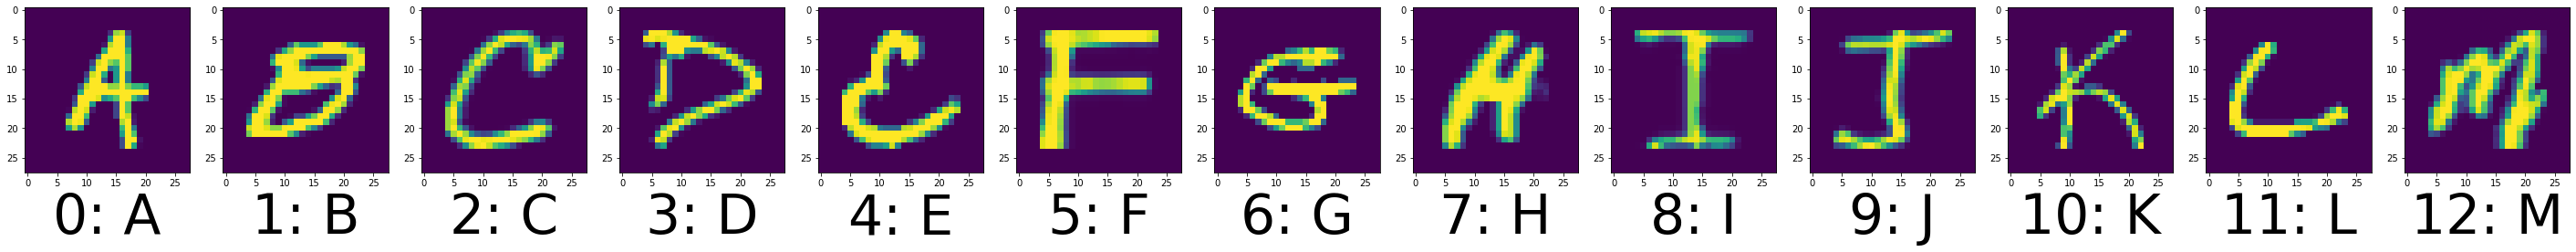

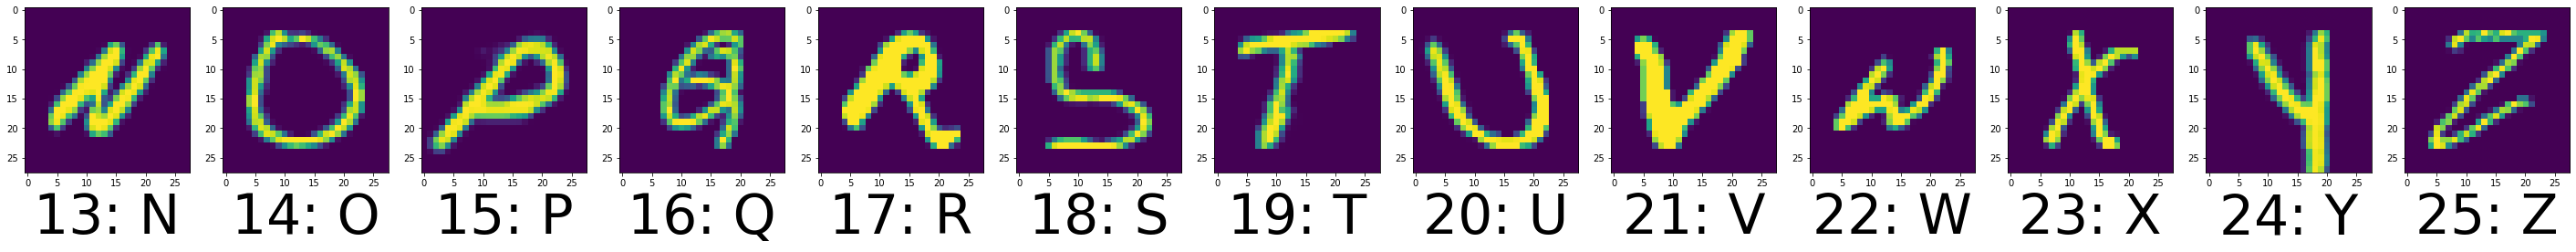

In [39]:
for row in range(2):
    plt.figure(figsize = (50, 10))
    r, c = 1, 13
    for i in range(r * c):  
        plt.subplot(r, c, i+1)
        a, b = letters[i+13*row][0]
        plt.imshow(a.permute(1, 2, 0))
        plt.xlabel(str(i+13*row) + ": " + numberToLetter[i+13*row], fontsize = 60)
    plt.show()

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [41]:
print("Total", n_total)
train_set = []
validation_set = []
test_set = []
for lista in letters:
    n = len(lista)
    n_train = int(0.8*n)
    n_validation = int(0.1*n)
    for i in range(n_train):
        train_set.append(lista[i])
    for i in range(n_train, n_train + n_validation):
        validation_set.append(lista[i])
    for i in range(n_train + n_validation, n):
        test_set.append(lista[i])

print("train set length:", len(train_set))
print("validation set length:", len(validation_set))
print("test set length:", len(test_set))
print("set type:", type(train_set))
print("data set type:", type(train_set[0]))
a, b = train_set[0] 
print("first data set type:", type(a))
print("first data shape:", a.shape)
print("second data set type:", type(b))
print("second data shape:", b.shape)

Total 372451
train set length: 297951
validation set length: 37234
test set length: 37266
set type: <class 'list'>
data set type: <class 'tuple'>
first data set type: <class 'torch.Tensor'>
first data shape: torch.Size([1, 28, 28])
second data set type: <class 'torch.Tensor'>
second data shape: torch.Size([26])


In [42]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [43]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    validation_loss_avg = []
    
    for epoch in range(Epochs):
        model.train()

        train_loss_avg.append(0)
        num_batches = 0
        total = 0
        correct = 0

        for image_batch, label_batch in train_loader:
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            
            label_batch_pred = model(image_batch)
            loss = loss_fn(label_batch_pred, label_batch)

            _, test = torch.max(label_batch.data, 1)
            _, predicted = torch.max(label_batch_pred.data, 1)
            total += label_batch.size(0)
            correct += (predicted == test).sum().item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        train_accuracy = 100.0 * correct / total 

        validation_loss_avg.append(0)
        num_batches = 0
        total = 0
        correct = 0

        model.eval()

        with torch.no_grad():
            for image_batch, label_batch in validation_loader:
                image_batch = image_batch.to(device)
                label_batch = label_batch.to(device)
            
                label_batch_pred = model(image_batch)
                loss = loss_fn(label_batch_pred, label_batch)

                _, test = torch.max(label_batch.data, 1)
                _, predicted = torch.max(label_batch_pred.data, 1)
                total += label_batch.size(0)
                correct += (predicted == test).sum().item()

                validation_loss_avg[-1] += loss.item()
                num_batches += 1

        validation_loss_avg[-1] /= num_batches
        validation_accuracy = 100.0 * correct / total

        print(f'Epoch [{epoch+1} / {Epochs}] training error: {train_loss_avg[-1]:.4f}, training accuracy: {train_accuracy:.4f}%, validation error: {validation_loss_avg[-1]:.4f}, validation accuracy: {validation_accuracy:.4f}%')
      
    return train_loss_avg, validation_loss_avg

In [44]:
def training_model(model, epoch, loss, optimizer, train_loader):
    training_loss, validation_loss = train(model,train_loader,epoch,loss)
    
    fig = plt.figure()
    plt.plot(training_loss, label = 'Training Loss')
    plt.plot(validation_loss, label = 'Validation Loss')
    plt.title("Loss graphic")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [45]:
def testing_model(model, test_loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for image_batch, label_batch in test_loader:
            image_batch = image_batch.to(device)

            label_batch_pred = model(image_batch)

            image_batch = image_batch.to('cpu')
            label_batch_pred = label_batch_pred.to('cpu')

            _, test = torch.max(label_batch.data, 1)
            _, predicted = torch.max(label_batch_pred.data, 1)
            total += label_batch.size(0)
            correct += (predicted == test).sum().item()
    print(f'Total tested: {total}')
    print(f'Correct tested: {correct}')
    print(f'Accuracy: {(100.0 * correct / total):.4f} %')

In [48]:
class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0)),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84, bias=True),
            nn.ReLU(inplace = True),
            nn.Linear(in_features=84, out_features=26, bias=True),
         )
        
    def forward(self, image):
        out = self.features(image)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

Epoch [1 / 30] training error: 0.1866, training accuracy: 94.8297%, validation error: 0.1285, validation accuracy: 96.3716%
Epoch [2 / 30] training error: 0.0976, training accuracy: 97.1928%, validation error: 0.1029, validation accuracy: 97.1075%
Epoch [3 / 30] training error: 0.0871, training accuracy: 97.5191%, validation error: 0.1078, validation accuracy: 96.8523%
Epoch [4 / 30] training error: 0.0794, training accuracy: 97.7221%, validation error: 0.0832, validation accuracy: 97.6903%
Epoch [5 / 30] training error: 0.0756, training accuracy: 97.8647%, validation error: 0.0888, validation accuracy: 97.5641%
Epoch [6 / 30] training error: 0.0728, training accuracy: 97.9409%, validation error: 0.0790, validation accuracy: 97.8944%
Epoch [7 / 30] training error: 0.0717, training accuracy: 97.9829%, validation error: 0.0887, validation accuracy: 97.8111%
Epoch [8 / 30] training error: 0.0690, training accuracy: 98.0151%, validation error: 0.1112, validation accuracy: 97.0914%
Epoch [9

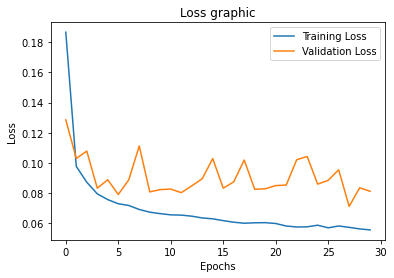

In [53]:
model = Lenet5()
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-5)
training_model(model, 30, loss, optimizer, train_loader)

In [54]:
testing_model(model, test_loader)

Total tested: 37266
Correct tested: 36573
Accuracy: 98.1404 %


In [55]:
torch.save(model, PATH + '/Lenet5.pt')

In [56]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.ReLU(inplace = True),
            nn.Linear(in_features=128, out_features=128, bias=True),
            nn.ReLU(inplace = True),
            nn.Linear(in_features=128, out_features=26, bias=True)
         )

    def forward(self, image):
        out = self.features(image)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

Epoch [1 / 30] training error: 0.1814, training accuracy: 95.0871%, validation error: 0.1205, validation accuracy: 97.0967%
Epoch [2 / 30] training error: 0.0933, training accuracy: 97.7634%, validation error: 0.0897, validation accuracy: 98.0018%
Epoch [3 / 30] training error: 0.0815, training accuracy: 98.1178%, validation error: 0.0920, validation accuracy: 97.9938%
Epoch [4 / 30] training error: 0.0727, training accuracy: 98.3632%, validation error: 0.0944, validation accuracy: 97.7145%
Epoch [5 / 30] training error: 0.0686, training accuracy: 98.4585%, validation error: 0.1124, validation accuracy: 97.4137%
Epoch [6 / 30] training error: 0.0607, training accuracy: 98.6458%, validation error: 0.1090, validation accuracy: 98.0475%
Epoch [7 / 30] training error: 0.0573, training accuracy: 98.7287%, validation error: 0.0809, validation accuracy: 98.3107%
Epoch [8 / 30] training error: 0.0585, training accuracy: 98.7367%, validation error: 0.1333, validation accuracy: 98.0529%
Epoch [9

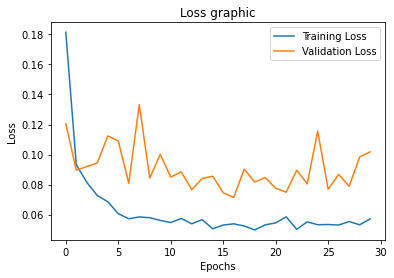

In [57]:
model = AlexNet()
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-5)
training_model(model, 30, loss, optimizer, train_loader)

In [58]:
testing_model(model, test_loader)

Total tested: 37266
Correct tested: 36723
Accuracy: 98.5429 %


In [59]:
torch.save(model, PATH + '/AlexNet.pt')

In [60]:
model = torch.load(PATH + '/Lenet5.pt')
model = model.to(device)
testing_model(model, test_loader)

Total tested: 37266
Correct tested: 36573
Accuracy: 98.1404 %


In [61]:
model = torch.load(PATH + '/AlexNet.pt')
model = model.to(device)
testing_model(model, test_loader)

Total tested: 37266
Correct tested: 36723
Accuracy: 98.5429 %
